In [1]:

!wget ftp://171.64.64.64/cs/cvgl/Stanford_Online_Products.zip
    # Set your own project id here


--2020-05-18 20:08:24--  ftp://171.64.64.64/cs/cvgl/Stanford_Online_Products.zip
           => ‘Stanford_Online_Products.zip’
Connecting to 171.64.64.64:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /cs/cvgl ... done.
==> SIZE Stanford_Online_Products.zip ... 3083860082
==> PASV ... done.    ==> RETR Stanford_Online_Products.zip ... done.
Length: 3083860082 (2.9G) (unauthoritative)

Stanford_Online_Pro 100%[===================>]   2.87G  16.2MB/s    in 2m 43s  

2020-05-18 20:11:09 (18.0 MB/s) - ‘Stanford_Online_Products.zip’ saved [3083860082]



In [2]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pickle
import cv2
from io import BytesIO
from PIL import Image
import zipfile as zip
import gc
from random import shuffle

import matplotlib.pyplot as plt

RESNET_D = False
RESNET_C = False
RESNET_B = False
BN_ZERO_GAMMA = False
CLASS_COUNT = 12


def MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=False):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,bias=bias)
    torch.nn.init.xavier_uniform_(conv.weight)
    if bias:
        torch.nn.init.zeros_(conv.bias)
    bn = nn.BatchNorm2d(out_channels, affine=True, track_running_stats=False)
    if BN_ZERO_GAMMA and zero_bn_gamma:
        torch.nn.init.zeros_(bn.weight)
    return nn.Sequential(conv, bn)


class ResNetBlockBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, is_downsample=False):
        super(ResNetBlockBottleneck, self).__init__()
        assert out_channels % 4 == 0
        self.in_channels = in_channels
        self.out_channels = out_channels
        internal_channels = out_channels // 4
        self.shortcut_is_needed = in_channels == out_channels
        if is_downsample:
            stride = 2
            if RESNET_D:
                self.shortcut = nn.Sequential(
                    nn.AvgPool2d((2, 2), stride=(stride, stride), padding=(0, 0)),
                    MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0),
                              bias=False, zero_bn_gamma=False)
                )
            else:
                self.shortcut = MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(stride, stride), padding=(0, 0),
                              bias=False, zero_bn_gamma=False)
                
        else:
            stride = 1
            self.shortcut = MyConv(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0),
                          bias=False, zero_bn_gamma=False)

        if RESNET_B:
            self.block = nn.Sequential(
                MyConv(in_channels, internal_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False),
                nn.ReLU(),
                MyConv(internal_channels, internal_channels, kernel_size=(3, 3), stride=(stride, stride), padding=(1, 1),
                          bias=False),
                nn.ReLU(),
                MyConv(internal_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=True)
            )
        else:
            self.block = nn.Sequential(
                MyConv(in_channels, internal_channels, kernel_size=(1, 1), stride=(stride, stride), padding=(0, 0), bias=False),
                nn.ReLU(),
                MyConv(internal_channels, internal_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),
                          bias=False),
                nn.ReLU(),
                MyConv(internal_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=False, zero_bn_gamma=True)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        #print(x.shape)
        return self.relu(self.block(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, class_count):
        super(ResNet, self).__init__()
        if RESNET_C:
            layers = [MyConv(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), 
                      MyConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      MyConv(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                      nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1))]
        else:
            layers = [MyConv(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
                      nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1))] 
        layers += [ResNetBlockBottleneck(64, 256, is_downsample=False)] + [ResNetBlockBottleneck(256, 256, is_downsample=False)] #* 2
        layers += [ResNetBlockBottleneck(256, 512, is_downsample=True)] + [ResNetBlockBottleneck(512, 512, is_downsample=False)] #* 3
        layers += [ResNetBlockBottleneck(512, 1024, is_downsample=True)] + [ResNetBlockBottleneck(1024, 1024, is_downsample=False)] #* 5
        layers += [ResNetBlockBottleneck(1024, 2048, is_downsample=True)] + [ResNetBlockBottleneck(2048, 2048, is_downsample=False)] #* 2
        layers += [nn.AvgPool2d((7, 7))]
        self.layers = nn.Sequential(
            *layers
        )
        self.decoder = nn.Linear(2048, class_count)
        torch.nn.init.xavier_uniform_(self.decoder.weight)
        torch.nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        return self.decoder(x)

dummy = torch.ones((1, 3, 224, 224))


loss_fn = nn.CrossEntropyLoss()
CUDA = torch.cuda.device_count()
device = 'cuda'
if False:
    model = ResNet(class_count=CLASS_COUNT)
    #print(model)
    print(model(dummy).shape)

In [3]:
if CUDA:
  print(torch.cuda.get_device_name(0))
  print(torch.cuda.memory_summary(device=0))
  print(torch.cuda.max_memory_allocated(device=0))
  

Tesla P100-PCIE-16GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |     

In [4]:
if True:
  print("Reading zip file into memory...",end="")
  with open('Stanford_Online_Products.zip',"rb") as f:
    zip_file_in_mem = f.read()
  print("OK")
  file_like_object = BytesIO(zip_file_in_mem)
  sopzip = zip.ZipFile(file_like_object,"r")

Reading zip file into memory...OK


In [5]:


SOP_DEFINITION = "/kaggle/input/sop-dataset/SOP_train_valid_split.pickle"


class SOP_classification(Dataset):
    def __init__(self, type='train', load_to_memory=True, transforms=None):
        assert type in ['test', 'train', 'valid']
        self.type = type
        self.load_to_memory = load_to_memory
        self.transforms = transforms
        self.samples = []
        self.labels = []
        self.toPIL = torchvision.transforms.ToPILImage()
        self.toTensor = torchvision.transforms.ToTensor()
        with open(SOP_DEFINITION, 'rb') as f:
            sop_dict = pickle.load(f)
        self.classes_names = sop_dict.keys()
        '''
            >>> data['bicycle_final']['train'].keys()
            dict_keys(['paths', 'product_labels', 'category_labels'])
        '''
        self.nrof_classes = len(self.classes_names)
        label_set = set()
        edge = 1000 if type=="train" else 300
        if True:
            for class_index, _class in enumerate(self.classes_names):
                print(f"\nhandling class {_class} ({class_index}/{self.nrof_classes}):")
                nrof_samples = len(sop_dict[_class][type]['paths'])
                for ind, name in enumerate(sop_dict[_class][type]['paths']):
                    print(f"\r\thandling image {ind}/{nrof_samples}: {name}...", end='')
                    self.samples.append(name[1:])
                    label = sop_dict[_class][type]['category_labels'][ind]
                    if label not in label_set:
                        label_set.add(label)
                    self.labels.append(label)
        print(f"\nCLASSES: {self.classes_names}: {label_set}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        name = self.samples[index]
        filedata = sopzip.read(name)
        dataEnc = BytesIO(filedata)
        sample = np.asanyarray(Image.open(dataEnc))
        if sample.ndim == 2:
            sample = cv2.cvtColor(sample, cv2.COLOR_GRAY2BGR)
        dataEnc.close()
        if self.transforms:
            sample = self.transforms(sample)
        return sample, self.labels[index]

In [6]:
train_transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(saturation=0.4, hue=0.4, brightness=0.4),
            transforms.ToTensor(),
            transforms.Normalize((123.68, 116.779, 103.939), (58.393, 57.12, 57.375))
        ]
    )

test_transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((123.68, 116.779, 103.939), (58.393, 57.12, 57.375))
        ]
    )
trainset = SOP_classification('train', load_to_memory=True, transforms=train_transform)
testset = SOP_classification('valid', load_to_memory=True, transforms=test_transform)


handling class cabinet_final (0/12):


	handling image 3904/7229: /Stanford_Online_Products/cabinet_final/151766741471_0.JPG...

	handling image 6041/7229: /Stanford_Online_Products/cabinet_final/151749465592_0.JPG...

	handling image 7228/7229: /Stanford_Online_Products/cabinet_final/261464973407_0.JPG...
handling class bicycle_final (1/12):


	handling image 2922/4978: /Stanford_Online_Products/bicycle_final/201392595572_0.JPG...

	handling image 4977/4978: /Stanford_Online_Products/bicycle_final/231493409797_1.JPG...
handling class chair_final (2/12):


	handling image 2193/7238: /Stanford_Online_Products/chair_final/271597331145_5.JPG...

	handling image 4461/7238: /Stanford_Online_Products/chair_final/131361891055_3.JPG...

	handling image 6617/7238: /Stanford_Online_Products/chair_final/181383497221_4.JPG...

	handling image 7237/7238: /Stanford_Online_Products/chair_final/161407030983_2.JPG...
handling class sofa_final (3/12):


	handling image 3658/4454: /Stanford_Online_Products/sofa_final/151691140368_6.JPG...

	handling image 4453/4454: /Stanford_Online_Products/sofa_final/261965607464_1.JPG...
handling class mug_final (4/12):


	handling image 3850/8165: /Stanford_Online_Products/mug_final/181824541286_0.JPG...

	handling image 5823/8165: /Stanford_Online_Products/mug_final/221846652422_4.JPG...

	handling image 7995/8165: /Stanford_Online_Products/mug_final/311219557553_1.JPG...

	handling image 8164/8165: /Stanford_Online_Products/mug_final/261973644335_6.JPG...
handling class stapler_final (5/12):


	handling image 3619/5023: /Stanford_Online_Products/stapler_final/261856842836_3.JPG...

	handling image 5022/5023: /Stanford_Online_Products/stapler_final/151752390342_0.JPG...
handling class toaster_final (6/12):


	handling image 2900/5216: /Stanford_Online_Products/toaster_final/321825043812_3.JPG...

	handling image 4302/5216: /Stanford_Online_Products/toaster_final/261927252636_3.JPG...

	handling image 5215/5216: /Stanford_Online_Products/toaster_final/190997089605_2.JPG...
handling class coffee_maker_final (7/12):


	handling image 3403/5815: /Stanford_Online_Products/coffee_maker_final/261990260861_8.JPG...

	handling image 5584/5815: /Stanford_Online_Products/coffee_maker_final/262003754014_5.JPG...

	handling image 5814/5815: /Stanford_Online_Products/coffee_maker_final/311413817362_5.JPG...
handling class table_final (8/12):


	handling image 4267/6659: /Stanford_Online_Products/table_final/301425273140_3.JPG...

	handling image 6658/6659: /Stanford_Online_Products/table_final/171261687946_2.JPG...
handling class fan_final (9/12):


	handling image 2352/3587: /Stanford_Online_Products/fan_final/371217814656_3.JPG...

	handling image 3586/3587: /Stanford_Online_Products/fan_final/371375925121_11.JPG...
handling class lamp_final (10/12):


	handling image 3299/7513: /Stanford_Online_Products/lamp_final/151749188589_5.JPG...

	handling image 5262/7513: /Stanford_Online_Products/lamp_final/221226757104_0.JPG...

	handling image 7016/7513: /Stanford_Online_Products/lamp_final/281649570997_4.JPG...

	handling image 7512/7513: /Stanford_Online_Products/lamp_final/252048612402_0.JPG...
handling class kettle_final (11/12):


	handling image 3849/6063: /Stanford_Online_Products/kettle_final/151727095742_6.JPG...

	handling image 6000/6063: /Stanford_Online_Products/kettle_final/252055260403_2.JPG...

	handling image 6062/6063: /Stanford_Online_Products/kettle_final/271526193068_9.JPG....
CLASSES: dict_keys(['cabinet_final', 'bicycle_final', 'chair_final', 'sofa_final', 'mug_final', 'stapler_final', 'toaster_final', 'coffee_maker_final', 'table_final', 'fan_final', 'lamp_final', 'kettle_final']): {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

handling class cabinet_final (0/12):
	handling image 2419/2420: /Stanford_Online_Products/cabinet_final/400882278599_0.JPG....
handling class bicycle_final (1/12):
	handling image 1662/1663: /Stanford_Online_Products/bicycle_final/331612287479_1.JPG....
handling class chair_final (2/12):
	handling image 2416/2417: /Stanford_Online_Products/chair_final/231393568323_0.JPG....
handling class sofa_final (3/12):
	handling image 1487/1488: /Stanford_Online_Products/sofa_final/371403550238_2.JPG....
handling class mug_final (4/12):
	handling image 2726/2727: /Stanford_Online_Products/mug_final/271077891525_0.JPG....
handling class stapler_final (5/12):
	hand

In [7]:
gc.collect()

20

torch.Size([80, 3, 224, 224]) torch.Size([80])


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch : 2, train loss : 2.6745, test loss : nan, test acc : 0.00%
epoch : 3, train loss : 2.3108, test loss : nan, test acc : 0.00%
epoch : 4, train loss : 1.7195, test loss : nan, test acc : 45.00%
epoch : 5, train loss : 1.1483, test loss : nan, test acc : 100.00%


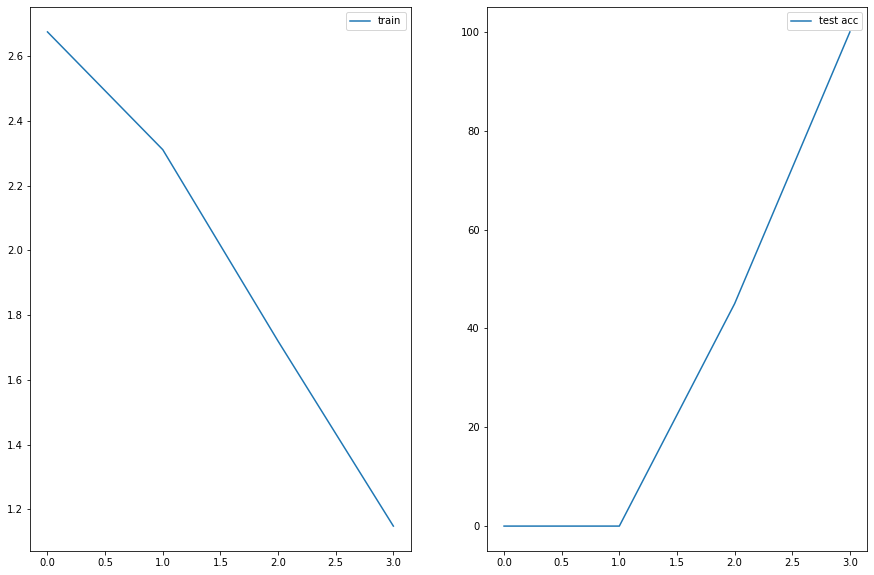

In [8]:
def one_batch():
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    model = ResNet(class_count=CLASS_COUNT)
    BS = 80
    test_loader = DataLoader(testset, batch_size=BS, shuffle=False)
    #train_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
    epochs = 0
    epoch = 0
    images, labels = iter(test_loader).next()
    print(images.shape, labels.shape)

    if CUDA:
        images = images.to(device)
        labels = labels.to(device)

        model.to(device)

    accuracy = 0
    while accuracy < 100:
        epoch += 1
        model.train()

        train_losses = []
        test_losses = []

        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        correct = 0
        total = 0

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        mean_train_losses.append(np.mean(train_losses))

        accuracy = 100 * correct / total
        test_acc_list.append(accuracy)
        print('epoch : {}, train loss : {:.4f}, test loss : {:.4f}, test acc : {:.2f}%' \
              .format(epoch + 1, np.mean(train_losses), np.mean(test_losses), accuracy))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax1.plot(mean_train_losses, label='train')
    # ax1.plot(mean_test_losses, label='test')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(test_acc_list, label='test acc')
    ax2.legend()
    plt.show()

if __name__=="__main__":
    one_batch()

In [9]:
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []
    model = ResNet(class_count=CLASS_COUNT)
    BS = 64
    test_loader = DataLoader(testset, batch_size=BS, shuffle=True, num_workers=0)
    train_loader = DataLoader(trainset, batch_size=BS, shuffle=True, num_workers=0)
    epochs = 100
    best_acc = 0
    PATH = "resne50.pt"
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    # model = torch.load(PATH)
    # model.eval()
    print("train started")
    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)
    for epoch in range(epochs):
        print(f"epoch : {epoch}")

        model.train()

        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        train_losses = []
        test_losses = []
        iter_count = len(train_loader)
        for i, (images, label_batch) in enumerate(train_loader):
            if CUDA:
                images = images.to(device)
                labels = label_batch.to(device)
            else:
                labels = label_batch

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            np.add.at(correct, label_batch[(predicted == labels)], 1)
            np.add.at(total,label_batch,1)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            print(f"\r\ttraining {i}/{iter_count} | curr_acc {np.round(correct / total,3)} loss: {train_losses[-1]}", end="")

        t_accuracy = correct.sum() / total.sum()
        train_acc_list.append(t_accuracy)
        model.eval()
        correct = np.zeros(CLASS_COUNT)
        total = np.zeros(CLASS_COUNT)
        print()
        iter_count = len(test_loader)
        with torch.no_grad():
            for i, (images, label_batch) in enumerate(test_loader):
                if CUDA:
                    images = images.to(device)
                    labels = label_batch.to(device)
                else:
                    labels = label_batch

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                
                
                test_losses.append(loss.item())

                _, predicted = torch.max(outputs.data, 1)
                np.add.at(correct, label_batch[(predicted == labels)], 1)
                np.add.at(total,label_batch,1)
                print(f"\r\tvalidating {i}/{iter_count} | curr_acc {np.round(correct / total,3)} test_loss: {test_losses[-1]}", end="")

        mean_train_losses.append(np.mean(train_losses))
        mean_test_losses.append(np.mean(test_losses))
        
        scheduler.step(mean_test_losses[-1])
        
        
        accuracy = correct.sum() / total.sum()
        balanced_test_acc.append(np.mean(accuracy))
        test_acc_list.append(accuracy)
        if False and accuracy > best_acc:
            torch.save(model, PATH)
            best_acc = accuracy
            print(f"Model was dumped to {PATH}")
        print('\n\ttrain loss : {:.4f}, test loss : {:.4f}, train acc : {}, test acc : {}' \
              .format(epoch + 1, np.mean(train_losses), np.mean(test_losses), np.round(t_accuracy,2), np.round(accuracy,2)))

train()

train started


NameError: name 'params' is not defined

In [ ]:
if True:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    ax1.plot(mean_train_losses, label='train')
    ax1.plot(mean_test_losses, label='test')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='best')

    ax2.plot(train_acc_list, label='train acc')
    ax2.plot(test_acc_list, label='test acc')
    ax2.legend()
    plt.show()